Домашняя работа Жеглова Дмитрия Андреевича.

In [1]:

import pandas as pd
import numpy as np
import xgboost as xgb
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set(style="white", color_codes=True)
import matplotlib.pyplot as plt
plt.style.use("ggplot")
#%matplotlib
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import KFold
from scipy.stats import skew, boxcox
from sklearn.preprocessing import StandardScaler
import itertools
from datetime import datetime
import time
import datetime
from pandas import DataFrame
from pandas.io.data import DataReader
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

In [2]:
Ee = pd.read_csv('data/EE.csv')

In [3]:
Ee.head()

,Name,Ticker,30D Vol,asset,YTD Return,flowytd,12M Yield,# of Holdings,Index Weight
0,SPDR S&P500 ETF Trust,SPY US,97139100,207616.0,8.05124,14030000000,2.03838,509,Market Cap
1,VanEck Vectors Gold Miners ETF,GDX US,81949900,10005.6,65.8163,3312000000,0.50989,53,Market Cap
2,iShares MSCI Emerging Markets,EEM US,71702800,27725.3,10.2703,4121000000,2.17723,844,Market Cap
3,Financial Select Sector SPDR F,XLF US,66580200,16648.2,13.4298,-1089000000,2.35225,65,Market Cap
4,iShares Russell 2000 ETF,IWM US,28428500,32255.5,11.8022,2923000000,1.43556,1968,Market Cap


изменим тип столбов с стринг на флоат

In [4]:
def fl(x):
    try:
        return float(x)
    except:
        return -1

In [5]:
Ee['ret12'] = Ee['12M Yield'].apply(fl)
Ee['hold'] = Ee['# of Holdings'].apply(fl)
Ee['retd'] = Ee['YTD Return'].apply(fl)

устрианим отрицательный поток наличности

In [6]:
def pos(x):
    if (x>0):
        return float(x)
    else:
        return -1*x
Ee.flowytd = Ee['flowytd'].apply(pos)

переведем категориальные фичи в числа

In [7]:
len(list(Ee['Ticker'].unique()))

540

слишком много значений,значит не будем переводить

In [8]:
len(list(Ee['Index Weight'].unique()))

9

тут немного значений переведем, как средние значения по нашим фичам

In [9]:
for column in ['Index Weight']:
    Ee[column+'30D Vol'] = Ee.groupby(column)['30D Vol'].transform('mean')
    Ee[column+'asset'] = Ee.groupby(column)['asset'].transform('mean')
    Ee[column+'flowytd'] = Ee.groupby(column)['flowytd'].transform('mean')
    Ee[column+'ret12'] = Ee.groupby(column)['ret12'].transform('mean')
    Ee[column+'hold'] = Ee.groupby(column)['hold'].transform('mean')
    #Ee[column+'retd'] = Ee.groupby(column)['retd'].transform('mean')
Ee.head()

,Name,Ticker,30D Vol,asset,YTD Return,flowytd,12M Yield,# of Holdings,Index Weight,ret12,hold,retd,Index Weight30D Vol,Index Weightasset,Index Weightflowytd,Index Weightret12,Index Weighthold
0,SPDR S&P500 ETF Trust,SPY US,97139100,207616.0,8.05124,14030000000,2.03838,509,Market Cap,2.03838,509,8.05124,2322679.343271,4874.102495,6.216847e+08,2.42986,515.601246
1,VanEck Vectors Gold Miners ETF,GDX US,81949900,10005.6,65.8163,3312000000,0.50989,53,Market Cap,0.50989,53,65.81630,2322679.343271,4874.102495,6.216847e+08,2.42986,515.601246
2,iShares MSCI Emerging Markets,EEM US,71702800,27725.3,10.2703,4121000000,2.17723,844,Market Cap,2.17723,844,10.27030,2322679.343271,4874.102495,6.216847e+08,2.42986,515.601246
3,Financial Select Sector SPDR F,XLF US,66580200,16648.2,13.4298,1089000000,2.35225,65,Market Cap,2.35225,65,13.42980,2322679.343271,4874.102495,6.216847e+08,2.42986,515.601246
4,iShares Russell 2000 ETF,IWM US,28428500,32255.5,11.8022,2923000000,1.43556,1968,Market Cap,1.43556,1968,11.80220,2322679.343271,4874.102495,6.216847e+08,2.42986,515.601246


In [10]:
Ee.describe()

,30D Vol,asset,flowytd,ret12,hold,retd,Index Weight30D Vol,Index Weightasset,Index Weightflowytd,Index Weightret12,Index Weighthold
count,540.000000,540.000000,5.400000e+02,540.000000,540.000000,540.000000,540.000000,540.000000,5.400000e+02,540.000000,540.000000
mean,1554037.633833,3317.820628,4.822715e+08,2.306025,403.527778,9.669623,1554037.633833,3317.820628,4.822715e+08,2.306025,403.527778
std,7470547.687102,11678.632850,1.214154e+09,2.662966,730.573946,14.121488,951724.291908,1921.114518,1.864519e+08,0.684754,161.816783
min,56.666700,100.451000,0.000000e+00,-1.000000,-1.000000,-42.330300,42764.650000,161.113000,7.752900e+07,1.344234,39.500000
25%,30327.400000,211.229250,3.772250e+07,1.314995,51.000000,2.533418,248836.687878,1044.723054,2.483525e+08,1.867935,225.472973
50%,109690.000000,590.191500,1.057000e+08,1.927175,123.000000,8.344060,2322679.343271,4874.102495,6.216847e+08,2.429860,515.601246
75%,424285.500000,2016.805000,3.464000e+08,2.713177,402.000000,13.935125,2322679.343271,4874.102495,6.216847e+08,2.429860,515.601246
max,97139100.000000,207616.000000,1.403000e+10,37.938100,7595.000000,118.560000,2322679.343271,4874.102495,7.208333e+08,7.718290,530.781250


In [11]:
Ee.drop(['12M Yield','# of Holdings','YTD Return','Index Weight'],axis=1,inplace = True)

In [12]:
np.mean(Ee['ret12'])

2.3060248333703703

In [13]:
Ee.head()

,Name,Ticker,30D Vol,asset,flowytd,ret12,hold,retd,Index Weight30D Vol,Index Weightasset,Index Weightflowytd,Index Weightret12,Index Weighthold
0,SPDR S&P500 ETF Trust,SPY US,97139100,207616.0,14030000000,2.03838,509,8.05124,2322679.343271,4874.102495,6.216847e+08,2.42986,515.601246
1,VanEck Vectors Gold Miners ETF,GDX US,81949900,10005.6,3312000000,0.50989,53,65.81630,2322679.343271,4874.102495,6.216847e+08,2.42986,515.601246
2,iShares MSCI Emerging Markets,EEM US,71702800,27725.3,4121000000,2.17723,844,10.27030,2322679.343271,4874.102495,6.216847e+08,2.42986,515.601246
3,Financial Select Sector SPDR F,XLF US,66580200,16648.2,1089000000,2.35225,65,13.42980,2322679.343271,4874.102495,6.216847e+08,2.42986,515.601246
4,iShares Russell 2000 ETF,IWM US,28428500,32255.5,2923000000,1.43556,1968,11.80220,2322679.343271,4874.102495,6.216847e+08,2.42986,515.601246


In [14]:
Xtr, Xval, ytr, yval = train_test_split(Ee,Ee.retd,random_state = 7, test_size=0.2)

In [18]:
feat = list(set(Ee.columns)-{"retd","Name","Ticker"} )
shift = 200

In [19]:
dtr = xgb.DMatrix(Xtr[feat], label=np.log(ytr+shift))
dval = xgb.DMatrix(Xval[feat], label=np.log(yval+shift))
watchlist = [(dtr, 'train'), (dval, 'eval')]
history = dict()

In [20]:
params = {
    'max_depth': 4,
    'eta': 0.05,
    'nthread': 4,
    'subsample': 0.99,
    'eval_metric': ['rmse'],
    'objective': 'reg:linear',
    'colsample_bytree': 0.9,
    'min_child_weight': 0,
    #'scale_pos_weight':(1-train.Label.mean())/train.Label.mean(),
    'seed':7
}

In [21]:
model = xgb.train(params, dtr, num_boost_round=300, evals=watchlist,evals_result=history, verbose_eval=5)

[0]	train-rmse:4.60106	eval-rmse:4.60782
[5]	train-rmse:3.56261	eval-rmse:3.56943
[10]	train-rmse:2.75863	eval-rmse:2.76552
[15]	train-rmse:2.13619	eval-rmse:2.14317
[20]	train-rmse:1.6544	eval-rmse:1.6615
[25]	train-rmse:1.28144	eval-rmse:1.2887
[30]	train-rmse:0.992863	eval-rmse:1.00032
[35]	train-rmse:0.769642	eval-rmse:0.777343
[40]	train-rmse:0.597058	eval-rmse:0.605073
[45]	train-rmse:0.463865	eval-rmse:0.472276
[50]	train-rmse:0.361101	eval-rmse:0.370005
[55]	train-rmse:0.282045	eval-rmse:0.291551
[60]	train-rmse:0.221485	eval-rmse:0.231668
[65]	train-rmse:0.175308	eval-rmse:0.186392
[70]	train-rmse:0.140299	eval-rmse:0.152914
[75]	train-rmse:0.113694	eval-rmse:0.128624
[80]	train-rmse:0.093974	eval-rmse:0.110934
[85]	train-rmse:0.079389	eval-rmse:0.098914
[90]	train-rmse:0.068693	eval-rmse:0.090542
[95]	train-rmse:0.061125	eval-rmse:0.084876
[100]	train-rmse:0.055385	eval-rmse:0.081258
[105]	train-rmse:0.051343	eval-rmse:0.079393
[110]	train-rmse:0.048506	eval-rmse:0.078145
[11

In [22]:
pred_xgb = model.predict(dval)
mean_absolute_error(np.exp(pred_xgb)-shift,yval)

9.7819725862268534

In [23]:
pred_xgb

array([ 5.33680868,  5.33992958,  5.34202433,  5.33711815,  5.32817221,
        5.5563612 ,  5.34798336,  5.3103857 ,  5.34771061,  5.34568357,
        5.33353281,  5.3277216 ,  5.33952045,  5.35826349,  5.33982182,
        5.30568981,  5.34939623,  5.3450036 ,  5.34248495,  5.38150883,
        5.35106421,  5.3314209 ,  5.33048248,  5.3468051 ,  5.32424831,
        5.34653521,  5.3410573 ,  5.3454814 ,  5.33884716,  5.34003496,
        5.32057571,  5.35234594,  5.34093475,  5.34802914,  5.35064745,
        5.33189678,  5.34270525,  5.29004955,  5.33159113,  5.34047127,
        5.35026884,  5.37519312,  5.33678484,  5.33419132,  5.32480764,
        5.33727694,  5.35943842,  5.34365988,  5.35107899,  5.34752274,
        5.33979845,  5.34814739,  5.33243036,  5.34815931,  5.26815224,
        5.31732321,  5.3561244 ,  5.33140278,  5.33360004,  5.35213232,
        5.32873869,  5.32820606,  5.3467226 ,  5.3198123 ,  5.33223867,
        5.31809902,  5.32501173,  5.34590387,  5.33353853,  5.34

In [24]:
yval

484     8.391630
194     6.394170
466    -1.547770
355     8.667330
284     8.609700
3      13.429800
50     32.753200
270    15.631200
308    11.147900
322    62.765100
521    10.632300
188     3.321110
319    23.800400
165     8.593500
55      8.124410
155    -1.383730
51      1.711650
408    10.344500
293     3.556830
425    54.268700
109    13.094400
382     5.164640
278    16.046900
179     3.964440
101     5.578010
490     8.105870
221     9.914890
65      3.279120
361    11.794100
132     7.312310
         ...    
388    23.726100
56    -14.218900
491     7.658600
253     3.753620
505    10.418000
510    10.591800
204    15.986100
350    10.749300
421     6.988970
381    19.701800
162    15.275000
420    12.265400
115     8.428870
273    19.639500
146    -0.843151
301    17.240200
468     3.872930
154    30.883400
60      3.675750
500     8.575890
414     6.752210
367     1.724380
465     3.598400
453    -6.663260
168     8.062130
359    12.305500
174   -18.690500
454    11.0450

Так как машинное обучение предсказывает всем примерно 5.3
Было решено отбирать акции без учета машинного обучения, а просто по показателям!
Отбирем по Yield 12 month 5 акций с наилучшим ростом начиная с 2009, 12, 20

In [36]:
z=0
k = -5
c = 0
while z<5:
    t = []
    z=0
    tic = list(Ee.sort(columns='ret12', axis=0)[k:].Ticker)
    for i in range(len(tic)):
        tic[i] = tic[i].split(' ')[0]
    symbols_list = tic#, 'YHOO','GOOG'

    symbols=[]
    for ticker in symbols_list: 
        r = DataReader(ticker, "yahoo", 
                       start=datetime.datetime(2009, 12, 20))
        # add a symbol column
        r['Symbol'] = ticker
        symbols.append(r)
    # concatenate all the dfs
    df = pd.concat(symbols)
    df = df.reset_index()
    dates = pd.to_datetime(df['Date'])
    df['Year'] = dates.apply(lambda x: x.year)
    df['Month'] = dates.apply(lambda x: x.month)
    df['Day'] = dates.apply(lambda x: x.day)
    df['Weekday'] = dates.apply(lambda x: x.weekday())
    for i in range(len(tic)):
        if len(df[(df['Symbol'] == tic[i]) & (df['Year'] == 2009)])>0:
            t.append(tic[i])
            z = z + 1
    k = k - 1 
    c = c+1
    print(z,k,c)
    if (c>30):
        print('err')
        break
t

2 -6 1
2 -7 2
3 -8 3
3 -9 4
3 -10 5
3 -11 6
3 -12 7
3 -13 8
3 -14 9
3 -15 10
4 -16 11
4 -17 12
4 -18 13
4 -19 14
5 -20 15


['PJP', 'AMJ', 'XPH', 'REM', 'EWM']

оставим только 5 которые начинаются с 2010

In [40]:
symbols_list = t#, 'YHOO','GOOG'
symbols=[]
for ticker in symbols_list: 
    r = DataReader(ticker, "yahoo", start=datetime.datetime(2010, 2, 1))
        # add a symbol column
    r['Symbol'] = ticker
    symbols.append(r)
    # concatenate all the dfs
df = pd.concat(symbols)
df = df.reset_index()
dates = pd.to_datetime(df['Date'])
df['Year'] = dates.apply(lambda x: x.year)
df['Month'] = dates.apply(lambda x: x.month)
df['Day'] = dates.apply(lambda x: x.day)
df['Weekday'] = dates.apply(lambda x: x.weekday())

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f0e8409ce80>>
Traceback (most recent call last):
  File "/home/dz/anaconda3/lib/python3.5/site-packages/xgboost/core.py", line 324, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'


добавим фичу размаха и разобьем на 5 акций, которые мы выбрали

In [46]:
df['razmah'] = df['High'] - df['Low']


добавим доходность

In [84]:
D1 = df[(df['Symbol'] == t[0]) & (df['Year'] >= 2010)]
D2 = df[(df['Symbol'] == t[1]) & (df['Year'] >= 2010)]
D3 = df[(df['Symbol'] == t[2]) & (df['Year'] >= 2010)]
D4 = df[(df['Symbol'] == t[3]) & (df['Year'] >= 2010)]
D5 = df[(df['Symbol'] == t[4]) & (df['Year'] >= 2010)]

In [85]:
D1['return'] = (D1['Close']-D1['Open'])/D1['Open']
D2['return'] = (D2['Close']-D2['Open'])/D2['Open']
D3['return'] = (D3['Close']-D3['Open'])/D3['Open']
D4['return'] = (D4['Close']-D4['Open'])/D4['Open']
D5['return'] = (D5['Close']-D5['Open'])/D5['Open']

In [86]:
D1['return'] = D1['return'].shift(-1)
D2['return'] = D2['return'].shift(-1)
D3['return'] = D3['return'].shift(-1)
D4['return'] = D4['return'].shift(-1)
D5['return'] = D5['return'].shift(-1)

In [87]:
len(D1),len(D2),len(D3),len(D4),len(D5)

(1726, 1726, 1726, 1726, 1726)

In [88]:
D1.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Symbol',
       'Year', 'Month', 'Day', 'Weekday', 'razmah', 'return'],
      dtype='object')

добавим фичей,скользящии среднии, delay(close), даты выбраны по количеству рабочих дней(неделя,месяц и т.д. за год)

In [89]:
for i in [1,2,3,4,5,10,15,21,42,63,84,105,126,147,168,189,210,231,252]:
    D1['moving_averages_Open_{}'.format(i)] = pd.rolling_mean(D1['Open'], i)
    D2['moving_averages_Open_{}'.format(i)] = pd.rolling_mean(D2['Open'], i)
    D3['moving_averages_Open_{}'.format(i)] = pd.rolling_mean(D3['Open'], i)
    D4['moving_averages_Open_{}'.format(i)] = pd.rolling_mean(D4['Open'], i)
    D5['moving_averages_Open_{}'.format(i)] = pd.rolling_mean(D5['Open'], i)
    D1['moving_averages_Close_{}'.format(i)] = pd.rolling_mean(D1['Close'], i)
    D2['moving_averages_Close_{}'.format(i)] = pd.rolling_mean(D2['Close'], i)
    D3['moving_averages_Close_{}'.format(i)] = pd.rolling_mean(D3['Close'], i)
    D4['moving_averages_Close_{}'.format(i)] = pd.rolling_mean(D4['Close'], i)
    D5['moving_averages_Close_{}'.format(i)] = pd.rolling_mean(D5['Close'], i)
    D1['delay_Open_{}'.format(i)] = D1.Open.shift(i)
    D2['delay_Open_{}'.format(i)] = D2.Open.shift(i)
    D3['delay_Open_{}'.format(i)] = D3.Open.shift(i)
    D4['delay_Open_{}'.format(i)] = D4.Open.shift(i)
    D5['delay_Open_{}'.format(i)] = D5.Open.shift(i)
    D1['delay_Close_{}'.format(i)] = D1.Close.shift(i)
    D2['delay_Close_{}'.format(i)] = D2.Close.shift(i)
    D3['delay_Close_{}'.format(i)] = D3.Close.shift(i)
    D4['delay_Close_{}'.format(i)] = D4.Close.shift(i)
    D5['delay_Close_{}'.format(i)] = D5.Close.shift(i)
D1.shape


(1726, 90)

In [91]:
def adv20(D1):
    return (D1.Volume.shift(1)+D1.Volume.shift(2)+D1.Volume.shift(3)+D1.Volume.shift(4)+D1.Volume.shift(5)+D1.Volume.shift(6)+D1.Volume.shift(7)+D1.Volume.shift(8)+D1.Volume.shift(9)+D1.Volume.shift(10)+D1.Volume.shift(11)+D1.Volume.shift(12)+D1.Volume.shift(13)+D1.Volume.shift(14)+D1.Volume.shift(15)+D1.Volume.shift(16)+D1.Volume.shift(17)+D1.Volume.shift(18)+D1.Volume.shift(19)+D1.Volume.shift(20))/20

добавим фундаментальный показатель(отношение дневного объема к среднему за 20 дней)

In [95]:
D1['volume/adv20'] = D1.Volume/adv20(D1)
D2['volume/adv20'] = D2.Volume/adv20(D2)
D3['volume/adv20'] = D3.Volume/adv20(D3)
D4['volume/adv20'] = D4.Volume/adv20(D4)
D5['volume/adv20'] = D5.Volume/adv20(D5)

In [96]:
print(D1.shape)
D1.tail()

(1726, 91)


,Date,Open,High,Low,Close,Volume,Adj Close,Symbol,Year,Month,...,delay_Close_210,moving_averages_Open_231,moving_averages_Close_231,delay_Open_231,delay_Close_231,moving_averages_Open_252,moving_averages_Close_252,delay_Open_252,delay_Close_252,volume/adv20
1721,2016-11-30,56.840000,56.840000,55.919998,56.020000,170600,56.020000,PJP,2016,11,...,60.259998,62.372857,62.343377,70.680000,69.970001,63.180794,63.145675,73.769997,74.459999,0.911617
1722,2016-12-01,56.180000,56.290001,55.110001,55.250000,153300,55.250000,PJP,2016,12,...,60.590000,62.318788,62.286970,68.669998,68.279999,63.108413,63.071587,74.419998,73.919998,0.807054
1723,2016-12-02,55.230000,55.779999,55.220001,55.439999,118200,55.439999,PJP,2016,12,...,60.830002,62.259913,62.228918,68.830002,68.849998,63.033532,63.006865,74.099998,71.750000,0.627405
1724,2016-12-05,55.619999,56.040001,55.279999,55.549999,151800,55.549999,PJP,2016,12,...,59.480000,62.206883,62.174069,67.870003,68.220001,62.968532,62.935635,72.000000,73.500000,0.837980
1725,2016-12-06,55.700001,55.750000,55.000000,55.459999,127100,55.459999,PJP,2016,12,...,58.169998,62.158441,62.128182,66.889999,66.059998,62.897857,62.868492,73.510002,72.379997,0.704956


удалим строки на котрых мы собирали информацию за год

In [97]:
D1.dropna(inplace = True)
D2.dropna(inplace = True)
D3.dropna(inplace = True)
D4.dropna(inplace = True)
D5.dropna(inplace = True)

In [98]:
D1.drop(['Date','Symbol'],axis=1,inplace = True)
D2.drop(['Date','Symbol'],axis=1,inplace = True)
D3.drop(['Date','Symbol'],axis=1,inplace = True)
D4.drop(['Date','Symbol'],axis=1,inplace = True)
D5.drop(['Date','Symbol'],axis=1,inplace = True)

попробуем предсказывать доходности на завтра

In [58]:
#D1['return'] = D1['return']*100
dataTest=D1[D1.Year>=2016]
dataTest.drop('Year', axis=1, inplace=True)
print(dataTest.shape)
dataTrain=D1[D1.Year<2016]
dataTrain.drop('Year', axis=1, inplace=True)
print(dataTrain.shape)

feat = list(set(dataTest.columns)-{"return"} )
shift = 200

dtr = xgb.DMatrix(dataTrain[feat], label=np.log(dataTrain['return']+shift))
dval = xgb.DMatrix(dataTest[feat], label=np.log(dataTest['return']+shift))
watchlist = [(dtr, 'train'), (dval, 'eval')]
history = dict()

params = {
    'max_depth': 4,
    'eta': 0.05,
    'nthread': 4,
    'subsample': 0.99,
    'eval_metric': ['rmse'],
    'objective': 'reg:linear',
    'colsample_bytree': 0.9,
    'min_child_weight': 0,
    #'scale_pos_weight':(1-train.Label.mean())/train.Label.mean(),
    'seed':7
}

model = xgb.train(params, dtr, num_boost_round=200, evals=watchlist,evals_result=history, verbose_eval=50)

pred1 = np.exp(model.predict(dval))-shift
np.sqrt(mean_squared_error(dataTest['return'], pred1))


(234, 88)
(1239, 88)
[0]	train-rmse:4.5586	eval-rmse:4.5586
[50]	train-rmse:0.351513	eval-rmse:0.351513
[100]	train-rmse:0.027106	eval-rmse:0.027105
[150]	train-rmse:0.00209	eval-rmse:0.00209


0.035962782059133822

In [59]:
#D1['return'] = D1['return']*100
dataTest=D2[D2.Year>=2016]
dataTest.drop('Year', axis=1, inplace=True)
print(dataTest.shape)
dataTrain=D2[D2.Year<2016]
dataTrain.drop('Year', axis=1, inplace=True)
print(dataTrain.shape)

feat = list(set(dataTest.columns)-{"return"} )
shift = 200

dtr = xgb.DMatrix(dataTrain[feat], label=np.log(dataTrain['return']+shift))
dval = xgb.DMatrix(dataTest[feat], label=np.log(dataTest['return']+shift))
watchlist = [(dtr, 'train'), (dval, 'eval')]
history = dict()

params = {
    'max_depth': 4,
    'eta': 0.05,
    'nthread': 4,
    'subsample': 0.99,
    'eval_metric': ['rmse'],
    'objective': 'reg:linear',
    'colsample_bytree': 0.9,
    'min_child_weight': 0,
    #'scale_pos_weight':(1-train.Label.mean())/train.Label.mean(),
    'seed':7
}

model = xgb.train(params, dtr, num_boost_round=200, evals=watchlist,evals_result=history, verbose_eval=50)

pred2 = np.exp(model.predict(dval))-shift
np.sqrt(mean_squared_error(dataTest['return'], pred1))


(234, 88)
(1239, 88)
[0]	train-rmse:4.5586	eval-rmse:4.55859
[50]	train-rmse:0.351514	eval-rmse:0.35151
[100]	train-rmse:0.027106	eval-rmse:0.027103
[150]	train-rmse:0.002091	eval-rmse:0.002088


0.038065762540834894

In [60]:
#D1['return'] = D1['return']*100
dataTest=D3[D3.Year>=2016]
dataTest.drop('Year', axis=1, inplace=True)
print(dataTest.shape)
dataTrain=D3[D3.Year<2016]
dataTrain.drop('Year', axis=1, inplace=True)
print(dataTrain.shape)

feat = list(set(dataTest.columns)-{"return"} )
shift = 200

dtr = xgb.DMatrix(dataTrain[feat], label=np.log(dataTrain['return']+shift))
dval = xgb.DMatrix(dataTest[feat], label=np.log(dataTest['return']+shift))
watchlist = [(dtr, 'train'), (dval, 'eval')]
history = dict()

params = {
    'max_depth': 4,
    'eta': 0.05,
    'nthread': 4,
    'subsample': 0.99,
    'eval_metric': ['rmse'],
    'objective': 'reg:linear',
    'colsample_bytree': 0.9,
    'min_child_weight': 0,
    #'scale_pos_weight':(1-train.Label.mean())/train.Label.mean(),
    'seed':7
}

model = xgb.train(params, dtr, num_boost_round=200, evals=watchlist,evals_result=history, verbose_eval=50)

pred3 = np.exp(model.predict(dval))-shift
np.sqrt(mean_squared_error(dataTest['return'], pred1))


(234, 88)
(1239, 88)
[0]	train-rmse:4.5586	eval-rmse:4.55859
[50]	train-rmse:0.351514	eval-rmse:0.35151
[100]	train-rmse:0.027106	eval-rmse:0.027103
[150]	train-rmse:0.002091	eval-rmse:0.002088


0.036772453905515493

In [61]:
#D1['return'] = D1['return']*100
dataTest=D4[D4.Year>=2016]
dataTest.drop('Year', axis=1, inplace=True)
print(dataTest.shape)
dataTrain=D4[D4.Year<2016]
dataTrain.drop('Year', axis=1, inplace=True)
print(dataTrain.shape)

feat = list(set(dataTest.columns)-{"return"} )
shift = 200

dtr = xgb.DMatrix(dataTrain[feat], label=np.log(dataTrain['return']+shift))
dval = xgb.DMatrix(dataTest[feat], label=np.log(dataTest['return']+shift))
watchlist = [(dtr, 'train'), (dval, 'eval')]
history = dict()

params = {
    'max_depth': 4,
    'eta': 0.05,
    'nthread': 4,
    'subsample': 0.99,
    'eval_metric': ['rmse'],
    'objective': 'reg:linear',
    'colsample_bytree': 0.9,
    'min_child_weight': 0,
    #'scale_pos_weight':(1-train.Label.mean())/train.Label.mean(),
    'seed':7
}

model = xgb.train(params, dtr, num_boost_round=200, evals=watchlist,evals_result=history, verbose_eval=50)

pred4 = np.exp(model.predict(dval))-shift
np.sqrt(mean_squared_error(dataTest['return'], pred1))


(234, 88)
(1239, 88)
[0]	train-rmse:4.55859	eval-rmse:4.5586
[50]	train-rmse:0.351514	eval-rmse:0.351519
[100]	train-rmse:0.027106	eval-rmse:0.027111
[150]	train-rmse:0.002091	eval-rmse:0.002096


0.035737317984789782

In [62]:
pred2

array([-0.03364563, -0.03364563, -0.03364563, -0.03364563, -0.03364563,
       -0.03364563, -0.03364563, -0.03364563, -0.03364563, -0.03364563,
       -0.03364563, -0.03364563, -0.03364563, -0.03364563, -0.03364563,
       -0.03364563, -0.03364563, -0.03364563, -0.03364563, -0.03364563,
       -0.03364563, -0.03364563, -0.03364563, -0.03364563, -0.03364563,
       -0.03364563, -0.03364563, -0.03364563, -0.03364563, -0.03364563,
       -0.03364563, -0.03364563, -0.03364563, -0.03364563, -0.03364563,
       -0.03364563, -0.03364563, -0.03364563, -0.03364563, -0.03364563,
       -0.03364563, -0.03364563, -0.03364563, -0.03364563, -0.03364563,
       -0.03364563, -0.03364563, -0.03364563, -0.03364563, -0.03364563,
       -0.03364563, -0.03364563, -0.03364563, -0.03364563, -0.03364563,
       -0.03364563, -0.03364563, -0.03364563, -0.03364563, -0.03364563,
       -0.03364563, -0.03364563, -0.03364563, -0.03364563, -0.03364563,
       -0.03364563, -0.03364563, -0.03364563, -0.03364563, -0.03

Видим что предсказывается константа , значит модель плохо обучается, значит попробуем торговать по какому-нибудь сигналу.

Проверим длину тестовой выборки

In [99]:
len(D1),len(D2),len(D3),len(D4),len(D5)

(1473, 1473, 1473, 1473, 1473)

In [100]:
D1.head()

,Open,High,Low,Close,Volume,Adj Close,Year,Month,Day,Weekday,...,delay_Close_210,moving_averages_Open_231,moving_averages_Close_231,delay_Open_231,delay_Close_231,moving_averages_Open_252,moving_averages_Close_252,delay_Open_252,delay_Close_252,volume/adv20
252,23.059999,23.150000,22.969999,23.090000,13400,20.562936,2011,1,31,0,...,20.120001,20.738268,20.736017,19.350000,19.400000,20.570714,20.573968,18.700001,18.680000,0.397272
253,23.100000,23.379999,23.100000,23.290001,20200,20.741048,2011,2,1,1,...,20.150000,20.754329,20.752857,19.389999,19.400000,20.588254,20.591230,18.680000,18.940001,0.605062
254,23.180000,23.230000,23.139999,23.180000,36300,20.643086,2011,2,2,2,...,20.160000,20.770087,20.768355,19.540001,19.600000,20.605595,20.608571,18.809999,18.809999,1.122102
255,23.150000,23.219999,22.910000,23.209999,40900,20.669802,2011,2,3,3,...,20.049999,20.785455,20.784286,19.600000,19.530001,20.623770,20.628294,18.570000,18.240000,1.244864
256,23.219999,23.290001,23.120001,23.290001,13400,20.741048,2011,2,4,4,...,19.969999,20.801515,20.800563,19.510000,19.530001,20.643849,20.647937,18.160000,18.340000,0.405140


Начинаем торговлю с 2011 года

Попробуем торговать на разницах цены за неделю

In [190]:
p1d5 = D1.reset_index()['Close'] - D1.reset_index()['delay_Close_5']
p2d5 =  D2.reset_index()['Close'] - D2.reset_index()['delay_Close_5']
p3d5 = D3.reset_index()['Close'] - D3.reset_index()['delay_Close_5']
p4d5 = D4.reset_index()['Close'] - D4.reset_index()['delay_Close_5']
p5d5 = D5.reset_index()['Close'] - D5.reset_index()['delay_Close_5']

In [191]:
p1d4 = D1.reset_index()['Close'] - D1.reset_index()['delay_Close_4']
p2d4 =  D2.reset_index()['Close'] - D2.reset_index()['delay_Close_4']
p3d4 = D3.reset_index()['Close'] - D3.reset_index()['delay_Close_4']
p4d4 = D4.reset_index()['Close'] - D4.reset_index()['delay_Close_4']
p5d4 = D5.reset_index()['Close'] - D5.reset_index()['delay_Close_4']

In [192]:
p1d3 = D1.reset_index()['Close'] - D1.reset_index()['delay_Close_3']
p2d3 =  D2.reset_index()['Close'] - D2.reset_index()['delay_Close_3']
p3d3 = D3.reset_index()['Close'] - D3.reset_index()['delay_Close_3']
p4d3 = D4.reset_index()['Close'] - D4.reset_index()['delay_Close_3']
p5d3 = D5.reset_index()['Close'] - D5.reset_index()['delay_Close_3']

In [193]:
p1d2 = D1.reset_index()['Close'] - D1.reset_index()['delay_Close_2']
p2d2 =  D2.reset_index()['Close'] - D2.reset_index()['delay_Close_2']
p3d2 = D3.reset_index()['Close'] - D3.reset_index()['delay_Close_2']
p4d2 = D4.reset_index()['Close'] - D4.reset_index()['delay_Close_2']
p5d2 = D5.reset_index()['Close'] - D5.reset_index()['delay_Close_2']

In [194]:
p1d1 = D1.reset_index()['Close'] - D1.reset_index()['delay_Close_1']
p2d1 =  D2.reset_index()['Close'] - D2.reset_index()['delay_Close_1']
p3d1 = D3.reset_index()['Close'] - D3.reset_index()['delay_Close_1']
p4d1 = D4.reset_index()['Close'] - D4.reset_index()['delay_Close_1']
p5d1 = D5.reset_index()['Close'] - D5.reset_index()['delay_Close_1']

это плохой сигнал

In [184]:
#это плохой сигнал
#p1 = D1.reset_index()['volume/adv20']
#p2 = D2.reset_index()['volume/adv20']
#p3 = D3.reset_index()['volume/adv20']
#p4 = D4.reset_index()['volume/adv20']
#p5 = D5.reset_index()['volume/adv20']

In [208]:
p1 = p1d1 + p1d5 + p1d2+p1d3+p1d4
p2 = p2d1 + p2d5+p2d2+p2d3+p2d4
p3 = p3d1 + p3d5+p3d2+p3d3+p3d4
p4 = p4d1 + p4d5+p4d2+p4d3+p4d4
p5 = p5d1 + p5d5+p5d2+p5d3+p5d4

централизация(для short-long)

In [209]:
#M = p1+p2+p3+p4+p5
#p1 = p1 - M
#p2 = p2 - M
#p3 = p3 - M
#p4 = p4 - M
#p5 = p5 - M

нормирование

In [210]:
p = abs(p1) + abs(p2) +abs(p3)+abs(p4)+abs(p5)
p1 = p1/p
p2 = p2/p
p3 = p3/p
p4 = p4/p
p5 = p5/p

In [211]:
p1 = -p1
p2 = -p2
p3 = -p3
p4 = -p4
p5 = -p5

доходности

In [212]:
r1 = list(D1.reset_index()['return'])
r2 = list(D2.reset_index()['return'])
r3 = list(D3.reset_index()['return'])
r4 = list(D4.reset_index()['return'])
r5 = list(D5.reset_index()['return'])

симуляция торгов(бэктест)

In [213]:
y = [20000000]
for i in range(len(p1)):
    size = y[i]
    z= float(size)
    if np.sign(p1[i]) == np.sign(r1[i]):
        z = z+size*abs(p1[i])*(+abs(r1[i]))
    else:
        z = z+ size*abs(p1[i])*(-abs(r1[i]))
    print(z)
    if np.sign(p2[i]) == np.sign(r2[i]):
        z = z+size*abs(p2[i])*(+abs(r2[i]))
    else:
        z = z+size*abs(p2[i])*(-abs(r2[i]))
    print(z)
    if np.sign(p3[i]) == np.sign(r3[i]):
        z = z+size*abs(p3[i])*(+abs(r3[i]))
    else:
        z = z+size*abs(p3[i])*(-abs(r3[i]))
    print(z)
    if np.sign(p4[i]) == np.sign(r4[i]):
        z = z+size*abs(p4[i])*(+abs(r4[i]))
    else:
        z = z+size*abs(p4[i])*(-abs(r4[i]))
    print(z)
    if np.sign(p5[i]) == np.sign(r5[i]):
        z = z+size*abs(p5[i])*(+abs(r5[i]))
    else:
        z = z+size*abs(p5[i])*(-abs(r5[i]))
    print('!',np.int(z))
    
    y.append(np.int(z))

20037714.1966
20049065.7476
20070944.5844
20076873.1497
! 20098345
20098345.0
20088850.2074
20087317.1848
20063374.1758
! 20054957
20060478.4273
20049202.5092
20069971.5792
20081242.8077
! 20083225
20083862.4706
20134715.9827
20138820.096
20154170.3586
! 20129460
20140209.8509
20153657.2194
20193325.3459
20192631.4086
! 20166601
20159939.5911
20179848.8208
20176532.7388
20127290.1763
! 20173721
20173721.0
20171854.7605
20187072.2279
20202972.0615
! 20210525
20209621.734
20229015.6975
20234281.0175
20228264.168
! 20242738
20244936.2318
20232132.405
20248216.2341
20239350.6107
! 20294788
20302112.0329
20333160.6794
20328501.8891
20325066.8711
! 20305927
20294691.6136
20261506.853
20236692.0479
20247282.1482
! 20252807
20246160.8235
20253222.339
20232010.3285
20227365.7448
! 20236564
20221198.3805
20241993.9508
20236846.4734
20239526.5074
! 20237976
20245285.5697
20252181.2181
20275580.4172
20278602.3233
! 20274870
20289924.0857
20343088.5314
20385894.9811
20378006.8244
! 20401518
2035469

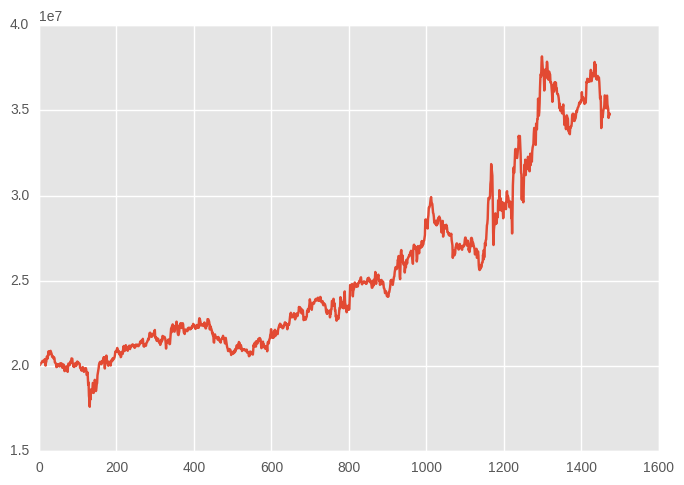

In [214]:
plt.plot(y)
plt.show()

Посмотрим что дает banchmark

In [215]:
stock = pd.read_csv('data/STOCK.csv')
dates = pd.to_datetime(stock['Date'])
stock['Year'] = dates.apply(lambda x: x.year)
stock = stock[stock['Year']>2011]
stock['last_price'] = (stock['PX_LAST'] - stock['PX_LAST'].shift(1))/stock['PX_LAST'].shift(1)
stock = stock.dropna()
retur_st = list(stock['last_price'])
price_st = list(stock['PX_LAST'])
ret_st = (price_st[-1]-price_st[0])/price_st[0]
ret_st

0.23824300304281018

In [216]:
bond = pd.read_csv('data/BOND.csv')
dates = pd.to_datetime(bond['Date'])
bond['Year'] = dates.apply(lambda x: x.year)
bond = bond[bond['Year']>2011]
bond['last_price'] = (bond['PX_LAST'] - bond['PX_LAST'].shift(1))/bond['PX_LAST'].shift(1)
bond = bond.dropna()
retur_b = list(bond['last_price'])
price_bond = list(bond['PX_LAST'])
ret_bond = (price_bond[-1]-price_bond[0])/price_bond[0]
ret_bond

0.13248773054254534

In [217]:
y[0]*0.6*ret_bond+y[0]*0.6*ret_st

4448768.8030242659

In [218]:
len(r1),len(r2)

(1473, 1473)

In [219]:
r1 =  list(retur_b)
r2 = list(retur_st)
r3 = np.arange(len(r2))
r4 = np.arange(len(r2))
r5 = np.arange(len(r2))

In [220]:
p1 = np.ones(len(r1))*0.6
p2 = np.ones(len(r1))*0.4
p3 = np.ones(len(r1))*0
p4 = np.ones(len(r1))*0
p5 = np.ones(len(r1))*0

In [221]:
y = [20000000]
for i in range(len(p1)):
    size = y[i]
    z= float(size)
    if np.sign(p1[i]) == np.sign(r1[i]):
        z = z+size*abs(p1[i])*(+abs(r1[i]))
    else:
        z = z+ size*abs(p1[i])*(-abs(r1[i]))
    print(z)
    if np.sign(p2[i]) == np.sign(r2[i]):
        z = z+size*abs(p2[i])*(+abs(r2[i]))
    else:
        z = z+size*abs(p2[i])*(-abs(r2[i]))
    print(z)
    if np.sign(p3[i]) == np.sign(r3[i]):
        z = z+size*abs(p3[i])*(+abs(r3[i]))
    else:
        z = z+size*abs(p3[i])*(-abs(r3[i]))
    print(z)
    if np.sign(p4[i]) == np.sign(r4[i]):
        z = z+size*abs(p4[i])*(+abs(r4[i]))
    else:
        z = z+size*abs(p4[i])*(-abs(r4[i]))
    print(z)
    if np.sign(p5[i]) == np.sign(r5[i]):
        z = z+size*abs(p5[i])*(+abs(r5[i]))
    else:
        z = z+size*abs(p5[i])*(-abs(r5[i]))
    print('!',np.int(z))
    
    y.append(np.int(z))

19997244.207
20383285.5776
20383285.5776
20383285.5776
! 20383285
20316274.0884
20349925.883
20349925.883
20349925.883
! 20349925
20485290.0497
20372214.5589
20372214.5589
20372214.5589
! 20372214
20482813.867
19721900.7959
19721900.7959
19721900.7959
! 19721900
19726539.0122
20100618.4095
20100618.4095
20100618.4095
! 20100618
20266968.4012
20367693.6793
20367693.6793
20367693.6793
! 20367693
20375677.0257
20533452.2059
20533452.2059
20533452.2059
! 20533452
20550410.9002
20791096.0518
20791096.0518
20791096.0518
! 20791096
20815631.9988
20752678.0801
20752678.0801
20752678.0801
! 20752678
20772326.5979
20862382.8904
20862382.8904
20862382.8904
! 20862382
20844558.2413
21022927.0917
21022927.0917
21022927.0917
! 21022927
20934704.0889
21314632.777
21314632.777
21314632.777
! 21314632
21378733.3563
21362646.8416
21362646.8416
21362646.8416
! 21362646
21372882.4105
21508617.7568
21508617.7568
21508617.7568
! 21508617
21639200.1112
21862852.4526
21862852.4526
21862852.4526
! 21862852
216

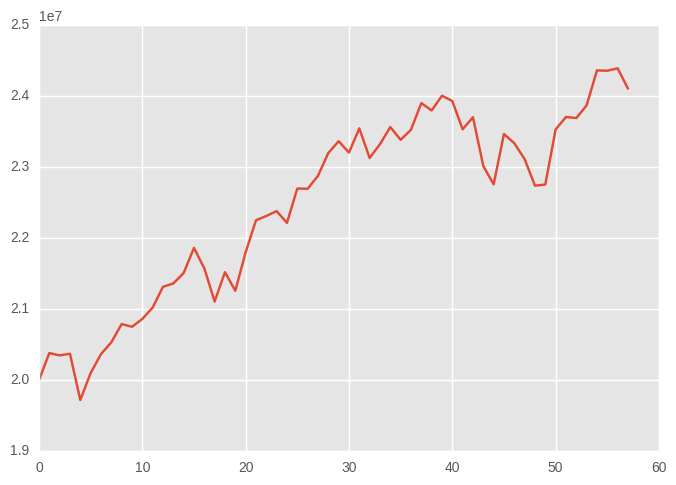

In [222]:
plt.plot(y)
plt.show()

видим, что наша стратегия дает лучший результат. Ура!